# Interpolation

Interpolationsverfahren können in der Geoökologie genutzt werden, um z.B. fehlende Datenpunkte in Zeitreihen zu schätzen. 

In diesem Skript arbeiten mit stündlichen Temperaturdaten von der Wetterstation am Telegrafenberg in Potsdam, welche vom Deutschen Wetterdienst bereitgestellt werden.

In [205]:
import numpy as np
import matplotlib.pyplot as plt

c2="#fdae6b" # Farbdefinition


Wir ein weiteres sehr nützliches Python-Paket: `Pandas` um Zeitreihen einzulesen und zu bearbeiten. Das Paket ermöglicht die Arbeit mit Dataframes, welche Daten verschiedener Datentypen in einer 2 dimensionalen Tabelle mit Zeilen und Spalten enthalten kann. Pandas baut dabei auf numerischen Berechnungen von `NumPy` auf und erweitert diese um vielen nützliche Funktionen.

In [206]:

import pandas as pd

Zunächst lesen wir die Daten ein. Diese können auch direkt im Climate Data Center des DWD heruntergeladen werden ([hier](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/recent/stundenwerte_TU_03987_akt.zip)).

**Achtung:** Der Pfad ist relativ zu dem Pfad in dem das Skript liegt definiert (`./data/`)

In [207]:
data = pd.read_csv("./data/stundenwerte_TU_03987_akt/produkt_tu_stunde_20211105_20230508_03987.txt",sep=";")
data.index = pd.to_datetime(data.MESS_DATUM,format="%Y%m%d%H") # Formatierung des Indexes als Datumsformat

Wir stellen die gesamte Zeitreihe dar:

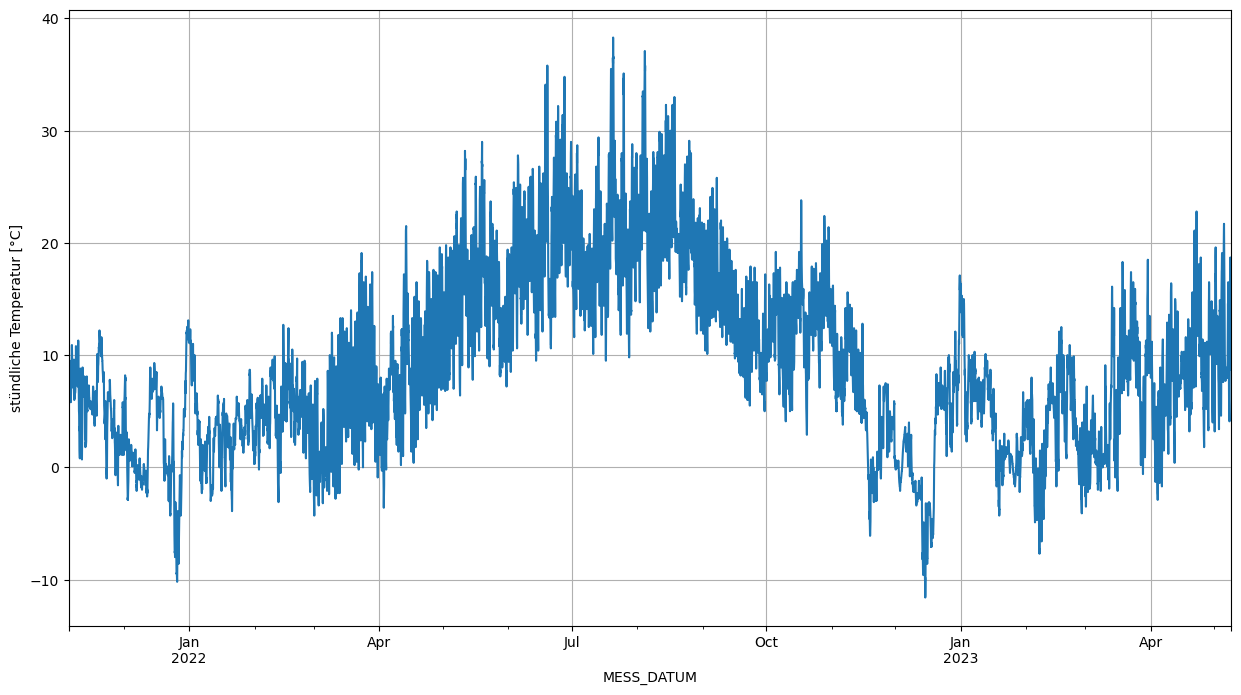

In [208]:
data["TT_TU"].plot(ylabel="stündliche Temperatur [°C]" ,
                   figsize=(15,8))

plt.grid()

Als nächstes wählen wir nur die letzten 30 Datenpunkte aus:

In [209]:

subset = data.tail(30)["TT_TU"]

stellen diese dar:

Text(0.5, 0, 'Zeit [Std]')

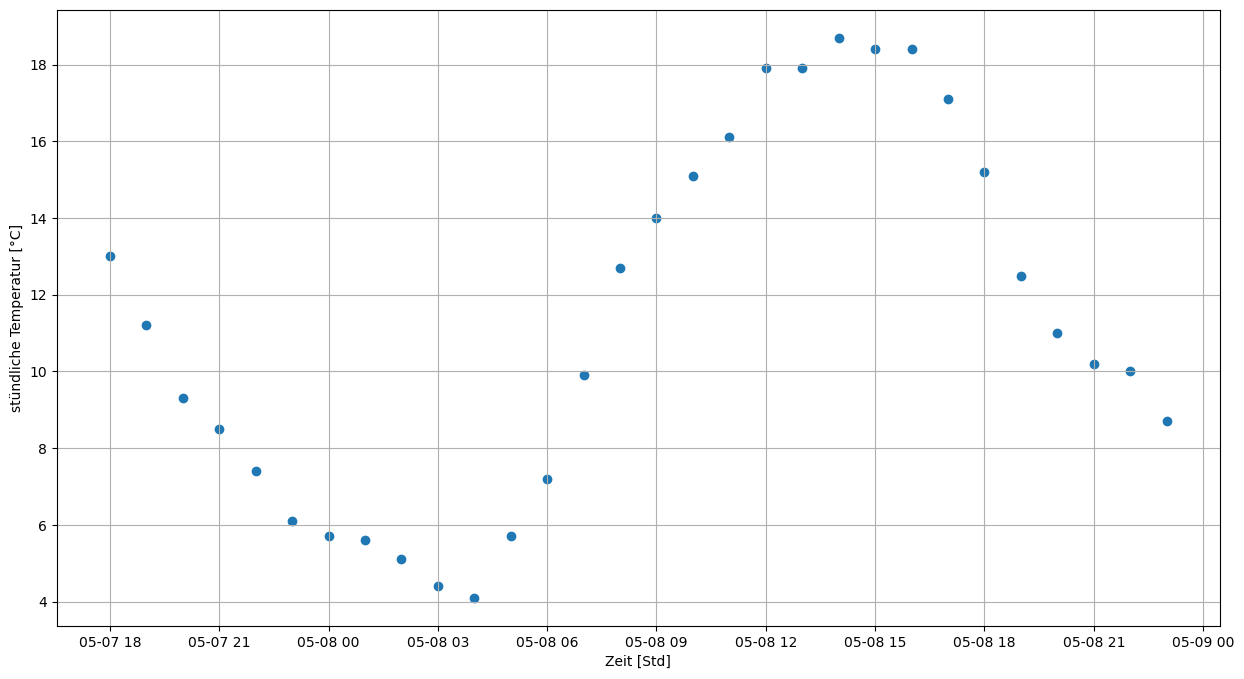

In [221]:


plt.figure(figsize=(15,8))
plt.grid()
plt.scatter(x=subset.index,
                    y=subset)
plt.ylabel(ylabel="stündliche Temperatur [°C]" )
plt.xlabel("Zeit [Std]")



Da in dieser Zeitreihe alle stündlichen Datenpunkte vorhanden sind, 
werden wir jeweils einen Datenpunkt entfernen bzw. auf NaN setzen (NaN= "Not a Number") und diesen mit linear und kubischem Spline interpolieren.
Damit können wir danach visualieren wie stark der interpolierte Wert vom gemessenen Wert abweicht.

In [215]:

t = 10 # Zeitschritt t (index), an welchem der Datenpunkt entfernt wird.

subset_nan = subset.copy()
subset_nan[t] = np.nan

y = subset[t]
x = subset.index[t]

### lineare Interpolation:

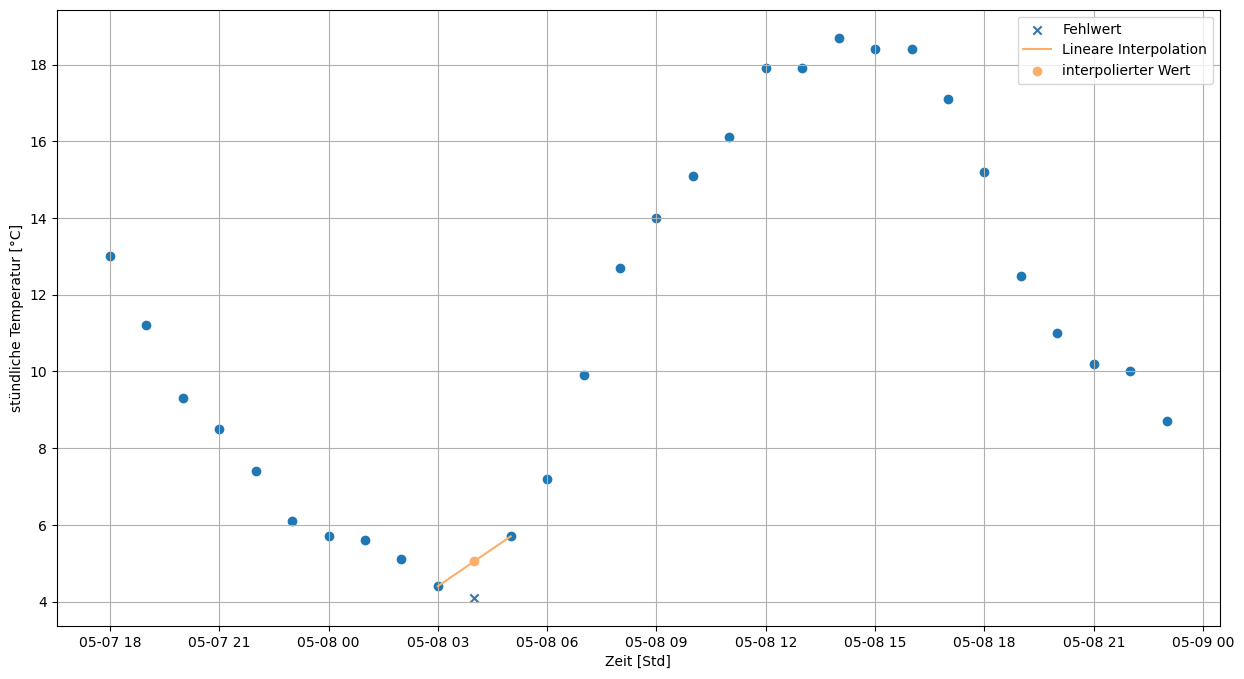

interpoliert: 5.050000000000001
original: 4.1
Absoluter Fehler: 0.9500000000000011


In [230]:

def lin_interpolation(x,y1,x1,y2,x2):
    '''
    Diese Funktion berechnet den y-Wert ein
    '''
    m = (y2-y1)/(x2 - x1) # Steigung der Geraden
    y = m * (x -x1) + y1 # Lineare Funktion
    return y

def convert_timestamp_float(x):
    # 
    return float(x.to_datetime64())
subset_nan = subset.copy()
t = 10 # Zeitpunkt t (index)
subset_nan[t] = np.nan
y = subset[t]
x = subset.index[t]


plt.figure(figsize=(15,8))
plt.grid()
# plt.plot(subset_nan.index,subset_nan,ls="--",alpha=0.7)
# subset_nan.plot(alpha=0.7)


x1 = subset.index[t-1] # X-Wert vor t
x2 = subset.index[t+1] # X-Wert nach t
y1 = subset[t-1] # Y-Wert vor t
y2 = subset[t+1] # Y-Wert nach t
y_interp = lin_interpolation(x = convert_timestamp_float(x),
                            x1 = convert_timestamp_float(x1),
                            y1 = y1,
                            x2 = convert_timestamp_float(x2),
                            y2 = y2)

plt.scatter(subset_nan.index,subset_nan) # Plotte die Datenpunkte
plt.scatter(x,y,marker="x",label="Fehlwert",color="#3776ab") # Plotte den "Fehlwert"

plt.plot([x1,x2],[y1,y2], label="Lineare Interpolation",color=c2) # Plotte die lineare Funktion
plt.scatter(x,y_interp,color=c2,label="interpolierter Wert") # Plotte den interpolierten Wert
plt.legend()
plt.ylabel(ylabel="stündliche Temperatur [°C]" )
plt.xlabel("Zeit [Std]")
plt.show()

print("interpoliert: " + str(y_interp))
print("original: " + str(y))
print("Absoluter Fehler: " + str(abs(y-y_interp)))

### kubische Spline-Interpolation:

Für die Berechnung der kubische Spline Interpolation nutzen wir das die Funktion `CubicSpline` aus dem Paket `scipy`. Die kubische Spline Methode nutzt Polynome dritten Grades.

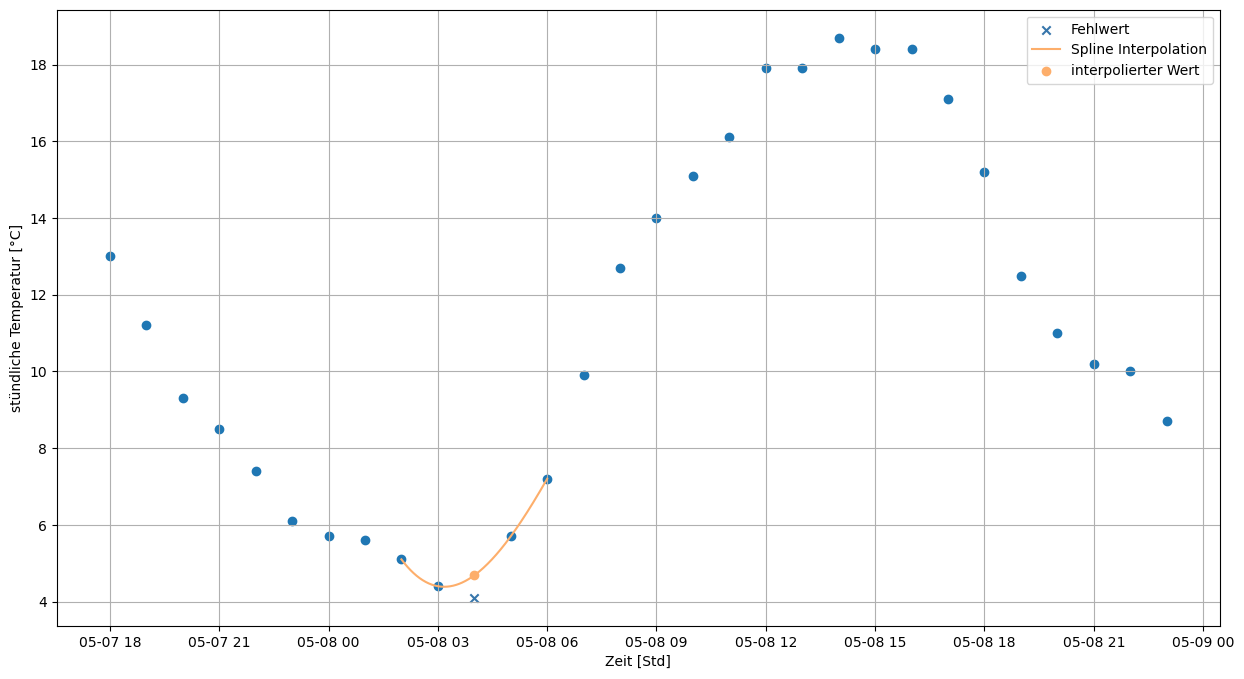

interpoliert: 4.683333333333334
original: 4.1
Absoluter Fehler: 0.5833333333333339


In [229]:
from scipy.interpolate import CubicSpline

subset_spline = subset[[t-2,t-1,t+1,t+2]]
# subset_spline = subset[[t-3,t-2,t-1,t+1,t+2,t+3]]
CS = CubicSpline(subset_spline.index, subset_spline.values)

x_spline = pd.date_range(subset_spline.index[0],subset_spline.index[-1],freq="min")
y_interp_spline = CS(convert_timestamp_float(x))

plt.figure(figsize=(15,8))
plt.grid()

plt.scatter(subset_nan.index,subset_nan) # Datenpunkte
plt.scatter(x,y,marker="x",label="Fehlwert",color="#3776ab") # Fehlwert

plt.plot(x_spline,CS(x_spline), label = "Spline Interpolation",color=c2) # Splineinterpolation um Fehlwert
plt.scatter(x,y_interp_spline,color=c2,label="interpolierter Wert") # interpolierter Wert

plt.ylabel(ylabel="stündliche Temperatur [°C]" )
plt.xlabel("Zeit [Std]")
plt.legend()
plt.show()
print("interpoliert: " + str(y_interp_spline))
print("original: " + str(y))
print("Absoluter Fehler: " + str(abs(y-y_interp_spline)))

**Fragen:**

- von welchen Faktoren könnte die sinnvolle Anwendung von Interpolation von Fehlwerten abhängen?